### 비트 코인 가격 예측  
https://www.blockchain.com/explorer/charts/market-price

- auto_arima를 사용하여 적합한 모델을 찾고, 이를 통해 금융 데이터 포트폴리오를 제작한다.

In [1]:
import pandas as pd
import json

# 2021-06 ~ 2024-06까지의 비트코인 가격 데이터(json) 가져오기
with open('./datasets/bitcoin_2022_2024.json') as f:
    json_data = json.load(f)

# 위 json 데이터의 market-price를 pandas 데이터프레임으로 변환
bitcoin_df = pd.DataFrame(json_data['market-price'])

In [2]:
# 데이터프레임 확인
bitcoin_df

,x,y
0,1623628800000,39066.82
1,1623715200000,40525.80
2,1623801600000,40188.56
3,1623888000000,38324.87
4,1623974400000,38068.04
...,...,...
1090,1717804800000,69331.66
1091,1717891200000,69297.93
1092,1717977600000,69645.28
1093,1718064000000,69513.23


In [3]:
from datetime import datetime

# timestamp(밀리초)를 년-월-일 형식으로 변환하는 함수
def changeDate(milis):
    timestamp = milis / 1000
    converted_time = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

    return converted_time

In [4]:
# 데이터프레임의 x(timestamp)에 함수를 적용하여 년-월-일 형태로 변환
bitcoin_df.x = bitcoin_df.x.apply(changeDate)
bitcoin_df

,x,y
0,2021-06-14,39066.82
1,2021-06-15,40525.80
2,2021-06-16,40188.56
3,2021-06-17,38324.87
4,2021-06-18,38068.04
...,...,...
1090,2024-06-08,69331.66
1091,2024-06-09,69297.93
1092,2024-06-10,69645.28
1093,2024-06-11,69513.23


In [5]:
# x(시간)을 인덱스로 변경하고, 기존 인덱스는 제거
bitcoin_df.set_index('x', inplace=True)
bitcoin_df

,y
x,
2021-06-14,39066.82
2021-06-15,40525.80
2021-06-16,40188.56
2021-06-17,38324.87
2021-06-18,38068.04
...,...
2024-06-08,69331.66
2024-06-09,69297.93
2024-06-10,69645.28


In [6]:
# 데이터프레임 정보 확인
# 두 번째 줄에 Index라고 적혀 있기 때문에, 현재 인덱스는 일반 문자열 타입인 것을 알 수 있다
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 2021-06-14 to 2024-06-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1095 non-null   float64
dtypes: float64(1)
memory usage: 17.1+ KB


In [7]:
# to_datetime으로 인덱스를 datetime(날짜) 형태로 바꿔주면
# Index에서 DateTimeIndex로 형식이 바뀐 것을 확인할 수 있으며
# 비로소 ARIMA 모델로 분석할 수 있게 된다
bitcoin_df.index = pd.to_datetime(bitcoin_df.index)
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2021-06-14 to 2024-06-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1095 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


#### 데이터 시각화

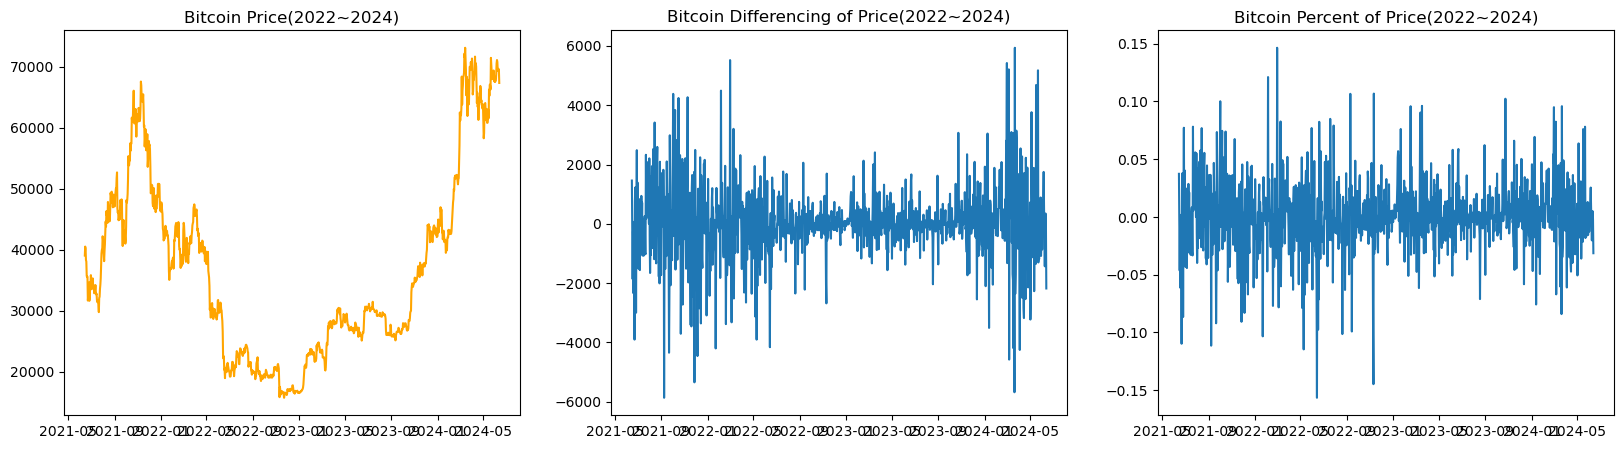

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(bitcoin_df, c='orange')
plt.title('Bitcoin Price(2022~2024)')

plt.subplot(1, 3, 2)
plt.plot(bitcoin_df.diff())
plt.title('Bitcoin Differencing of Price(2022~2024)')

plt.subplot(1, 3, 3)
plt.plot(bitcoin_df.pct_change())
plt.title('Bitcoin Percent of Price(2022~2024)')

plt.show()

### auto_arima

#### 데이터 분할

In [9]:
# train과 test를 8:2 비율로 분할 (앞쪽 80%:뒤쪽 20%)
y_train = bitcoin_df['y'][:int(0.8 * len(bitcoin_df))]
y_test = bitcoin_df['y'][int(0.8 * len(bitcoin_df)):]

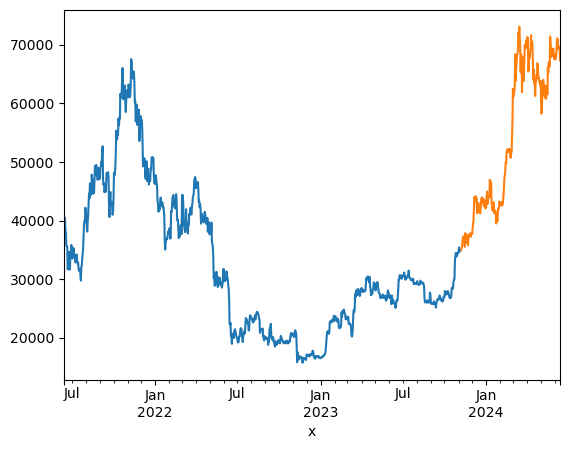

In [10]:
# train, test 그래프 시각화
y_train.plot()
y_test.plot()

plt.show()

In [11]:
from pmdarima.arima import ndiffs

# 차분 수를 구하는 서로 다른 알고리즘 3가지로 최적의 차분 수 구하기
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=10)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=10)
pp_diffs = ndiffs(y_train, alpha=0.05, test='pp', max_d=10)

# 위의 3가지 방식으로 최적 차분 수를 구한 뒤, 그 중 최대 값을 구한다
# 여기서 나온 차수를 아래의 auto_arima의 차분 수(d) 파라미터에 할당하면 된다
n_diffs = max(kpss_diffs, adf_diffs, pp_diffs)

print(f'd = {n_diffs}')

d = 1


#### 중간 분석
- 위 알고리즘 결과에 따라 auto_arima의 d(차분 수)는 1로 설정

In [12]:
import pmdarima as pm

# auto_arima로 최적의 파라미터를 탐색하고, 그 때의 파라미터를 모델에 자동 할당
model = pm.auto_arima(y=y_train,
                      d=1,
                      start_p=0, max_p=10,
                      start_q=0, max_q=10,
                      m=1,
                      stepwise=True,
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14747.539, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14748.503, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14748.388, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14745.555, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14749.325, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.246 seconds


In [13]:
# 다양한 모델 성능 지표 출력
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  876
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7371.777
Date:                Wed, 12 Jun 2024   AIC                          14745.555
Time:                        11:23:39   BIC                          14750.329
Sample:                    06-14-2021   HQIC                         14747.381
                         - 11-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.216e+06   3.17e+04     38.398      0.000    1.15e+06    1.28e+06
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               826.28
Prob(Q):                              0.73   Pr

#### 모델 분석
- Prob(Q): 0.05 이상으로 측정되었기 때문에  
  이 데이터는 서로 독립적이며 동일한 분포를 따른다고 할 수 있다.
- Prob(H): 0.05 미만으로 측정되었기 때문에
  이 데이터는 잔차(실제-예측값 차이)의 분산이 일정하지 않다고 할 수 있다.
- Prob(JB): 0.05 미만으로 측정되었기 때문에  
  평균과 분산이 일정하지 않다고 할 수 있다.
- Skew: 수치 상으로 볼 때, 이 데이터는 분포가 왼쪽에 약간 쏠려있다고 할 수 있다.
- Kurtosis: 약 7.7 정도가 측정되었기 때문에, 정규분포(Kurtosis=3)보다 첨도가 높다고 할 수 있다.

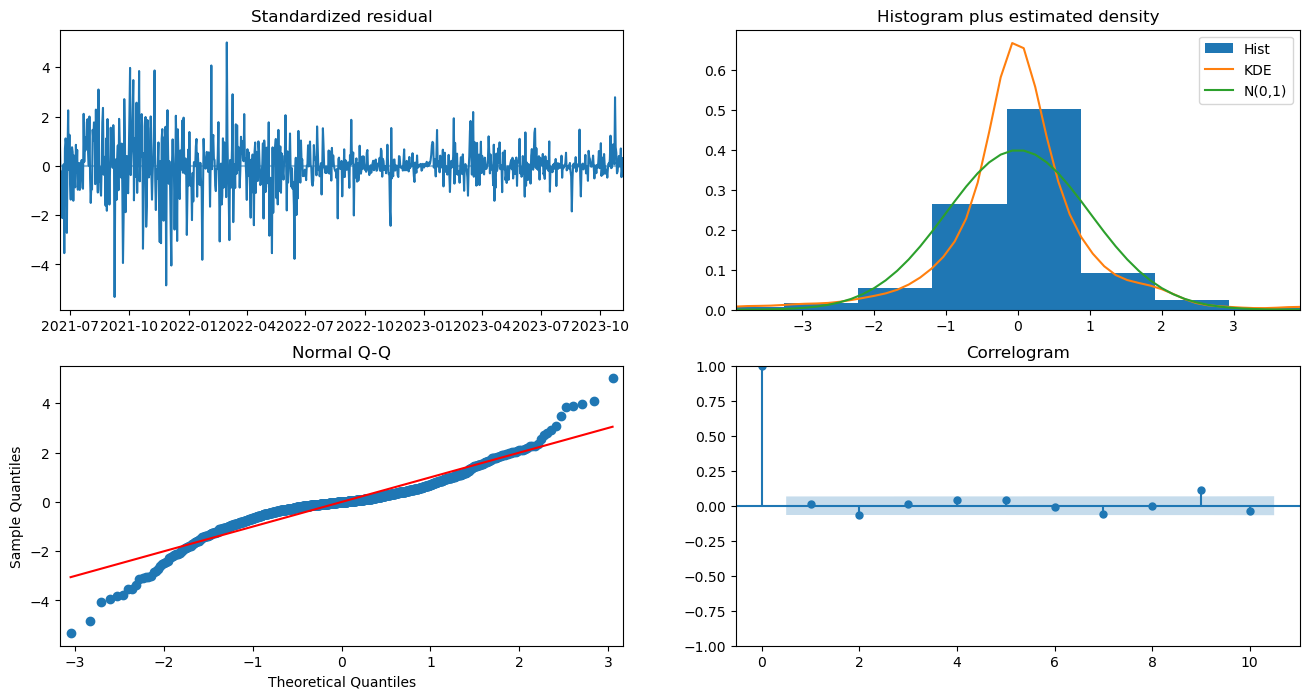

In [14]:
import matplotlib.pyplot as plt

# 모델의 차분, 분포, ACF 시각화
# 위의 summary와 맞아 떨어진다
model.plot_diagnostics(figsize=(16, 8))
plt.show()

#### 중간 분석
- 히스토그램(우상단)의 바 그래프 우측에 분포가 쏠려있는 형태를 보이는 것이  
  Normal Q-Q에서는 오른쪽 꼬리가 더 짧게 보이는 형태로 나타났다.
- 정규화된 잔차 그래프(좌상단)을 봤을 때, 분포가 음수 쪽에 조금 더 쏠려있다.

In [15]:
# 데이터 하나를 예측할 때마다의 결과를 반환하는 함수
def predict_one_step():
    prediction = model.predict(n_periods=1)
    return prediction.tolist()[0]

In [16]:
p_list = []

# test 데이터를 하나씩 예측하면서 예측값을 리스트에 담고, 하나의 데이터를 예측할 때마다 모델 업데이트
for data in y_test:
    p = predict_one_step()
    p_list.append(p)

    model.update(data)

In [17]:
# test 데이터의 라그 별 예측값을 데이터프레임으로 생성
y_predict_df = pd.DataFrame({"test": y_test, "pred": p_list})
y_predict_df

,test,pred
x,,
2023-11-07,35035.12,35048.35
2023-11-08,35436.28,35035.12
2023-11-09,35629.52,35436.28
2023-11-10,36696.25,35629.52
2023-11-11,37321.65,36696.25
...,...,...
2024-06-08,69331.66,70764.24
2024-06-09,69297.93,69331.66
2024-06-10,69645.28,69297.93


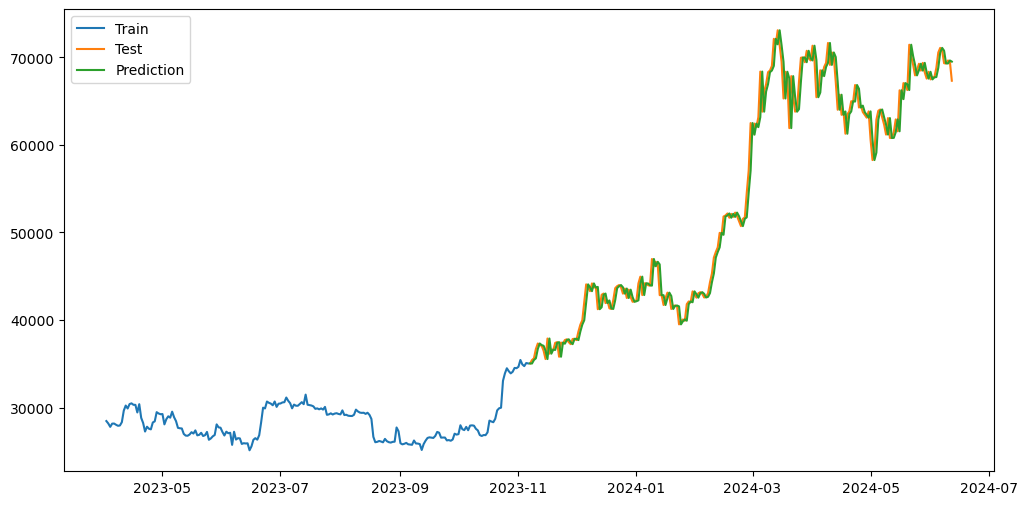

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# train, test와 예측값을 하나의 플롯에 시각화
# test와 예측 사이의 차이를 확인하는 것이 핵심
plt.plot(y_train.iloc[-219:], label='Train')
plt.plot(y_test.iloc[-219:], label='Test')
plt.plot(y_predict_df.pred, label='Prediction')
plt.legend()
plt.show()

In [26]:
import numpy as np

# 모델의 예측과 실제 데이터 간 오차(%)를 구해주는 함수
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# 모델의 예측과 실제 데이터 사이의 오차(%) 출력
print(f'MAPE (%): {MAPE(y_test, p_list):.4f}')

MAPE (%): 2.0292


#### 중간 분석
- 약 2% 정도의 오차 발생

### 심화 - Prophet (딥러닝)

In [39]:
# 2022-01-01부터의 데이터만 가져온 새로운 데이터프레임 생성
pre_b_df = bitcoin_df.loc['2022-01-01':]
pre_b_df

,y
x,
2022-01-01,46249.56
2022-01-02,47763.33
2022-01-03,47327.87
2022-01-04,46441.99
2022-01-05,45862.98
...,...
2024-06-08,69331.66
2024-06-09,69297.93
2024-06-10,69645.28


In [40]:
# 인덱스(날짜)를 다시 컬럼으로 만들고, 0번부터 시작되는 새로운 인덱스 생성
# Prophet() 객체에 넣어서 모델을 만들 때는 날짜가 인덱스면 안 되기 때문이다
pre_b_df = pre_b_df.reset_index()
pre_b_df

,x,y
0,2022-01-01,46249.56
1,2022-01-02,47763.33
2,2022-01-03,47327.87
3,2022-01-04,46441.99
4,2022-01-05,45862.98
...,...,...
889,2024-06-08,69331.66
890,2024-06-09,69297.93
891,2024-06-10,69645.28
892,2024-06-11,69513.23


In [41]:
# x(날짜) 컬럼의 이름을 ds로 변경
# Prophet 모델에서 사용하는 일종의 컨벤션이다
pre_b_df = pre_b_df.rename(columns={'x':'ds'})
pre_b_df

,ds,y
0,2022-01-01,46249.56
1,2022-01-02,47763.33
2,2022-01-03,47327.87
3,2022-01-04,46441.99
4,2022-01-05,45862.98
...,...,...
889,2024-06-08,69331.66
890,2024-06-09,69297.93
891,2024-06-10,69645.28
892,2024-06-11,69513.23


In [42]:
# train과 test를 8:2 비율로 분할 (앞쪽 80%:뒤쪽 20%)
train_df = pre_b_df[:int(0.8 * len(pre_b_df))]
test_df = pre_b_df[int(0.8 * len(pre_b_df)):]

In [46]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

# changepoint_prior_scale: trend의 변화량을 반영하는 정도 (default=0.05)
# seasonality_prior_scale: 계절성을 반영하는 정도
# seasonality_mode: 계절성으로 나타나는 효과를 더해나갈지(additive), 곱해나갈지(multiplicative) 정한다

# 교차 검증 (cross_validation)에 사용할 파라미터와 각 파라미터의 값들(list) 선언
search_space = {
    'changepoint_prior_scale': [0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
    'seasonality_prior_scale': [0.05, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# itertools.product: 각 요소들의 모든 경우의 수 조합을 생성
param_combinded = [dict(zip(search_space.keys(), v)) for v in itertools.product(*search_space.values())]

# train, test 데이터의 길이(len) 설정 - 전체 데이터를 8:2 비율로 분할
train_len = int(len(pre_b_df) * 0.8)
test_len = int(len(pre_b_df) * 0.2)

train_size = f'{train_len} days'
test_size = f'{test_len} days'

# pre_b_df의 앞쪽 80%는 train, 뒤쪽 20%는 test 데이터프레임으로 분할
train_df = pre_b_df.iloc[:train_len]
test_df = pre_b_df.iloc[train_len:]

mapes = []

# 각 파라미터 조합으로 Prophet 모델을 세팅하고,
# 해당 조합으로 train 데이터를 fit해서 나온 결과와 같이 데이터프레임 생성
for param in param_combinded:
    model = Prophet(**param)
    model.fit(train_df)

    # 'threads' 옵션은 메모리 사용량은 적지만, CPU 바운드 작업에는 효과적이지 않을 수 있다
    # 'dask' 옵션은 대규모 데이터를 처리하는 데 효과적이다
    # 'processes' 옵션은 각각의 작업을 별도의 프로세스로 실행하기 때문에
    # CPU 바운드 작업에 효과적이지만, 메모리 사용량이 많아질 수 있다 
    cv_df = cross_validation(model, initial=train_len, period='20 days', horizon=test_len, parallel='processes')
    df_p = performance_metrics(cv_df, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

# mape는 Mean Absolute Percentage Error (평균 절대비율 오차)의 약자
tuning_result = pd.DataFrame(param_combinded)
tuning_result['mape'] = mapes

14:02:11 - cmdstanpy - INFO - Chain [1] start processing
14:02:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 7 days which is larger than initial window. Consider increasing initial.
14:02:15 - cmdstanpy - INFO - Chain [1] start processing
14:02:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 7 days which is larger than initial window. Consider increasing initial.
14:02:19 - cmdstanpy - INFO - Chain [1] start processing
14:02:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 7 days which is larger than initial window. Consider increasing initial.
14:02:22 - cmdstanpy - INFO - Chain [1] start processing
14:02:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 7 days which is larger than initial window. Consider increasing initial.
14:02:26 - cmdstanpy - INFO - Chain [1] start processing
14:02:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 7 days which 

In [47]:
# 오차가 적은 순서대로 정렬해서 최적의 파라미터 조합 확인
tuning_result.sort_values(by='mape')

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mape
42,10.00,0.10,additive,0.068336
25,1.00,0.05,multiplicative,0.068502
26,1.00,0.10,additive,0.068582
31,1.00,10.00,multiplicative,0.069003
41,10.00,0.05,multiplicative,0.069175
24,1.00,0.05,additive,0.069187
43,10.00,0.10,multiplicative,0.069250
12,0.10,1.00,additive,0.069284
14,0.10,10.00,additive,0.069594
33,5.00,0.05,multiplicative,0.069681


In [54]:
# 위에서 확인한 최적의 파라미터 값으로 Prophet 모델 세팅
model = Prophet(changepoint_prior_scale=0.5, 
                seasonality_prior_scale=0.1,
                seasonality_mode='multiplicative')

# 파라미터 튜닝 후 전체 데이터 fit
model.fit(pre_b_df)

# 예측을 바탕으로 향후 1년(365일)간의 데이터 예측
future = model.make_future_dataframe(periods=365)

# 미래 데이터를 Prophet 모델로 예측하고, 예측 결과가 담긴 데이터프레임 출력
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][221:]

14:16:51 - cmdstanpy - INFO - Chain [1] start processing
14:16:51 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
221,2022-08-10,23286.931063,21149.259902,25295.640213
222,2022-08-11,23410.046095,21386.207204,25548.348944
223,2022-08-12,23315.499857,21125.268517,25386.282819
224,2022-08-13,23221.722458,21101.554278,25419.481548
225,2022-08-14,23153.414782,21077.573163,25193.635252
...,...,...,...,...
1254,2025-06-08,116739.185521,-50303.736100,297468.432895
1255,2025-06-09,116510.236786,-49820.185743,294520.282693
1256,2025-06-10,116913.138839,-51223.606588,296759.405552
1257,2025-06-11,115705.099413,-51233.159214,292748.203702


In [55]:
# pre_b_df를 복사한 뒤, 날짜를 인덱스로 지정
b_df = pre_b_df.copy()
b_df.set_index('ds', inplace=True)

# 미래 예측 데이터프레임을 복사한 뒤, 마찬가지로 날짜를 인덱스로 지정 
forecast_df = forecast.copy()
forecast_df = forecast_df.set_index('ds')

# 인덱스가 된 날짜(현재 문자열 타입)를 datetime 형식으로 변경
b_df.index = pd.to_datetime(b_df.index)
forecast_df.index = pd.to_datetime(forecast_df.index)

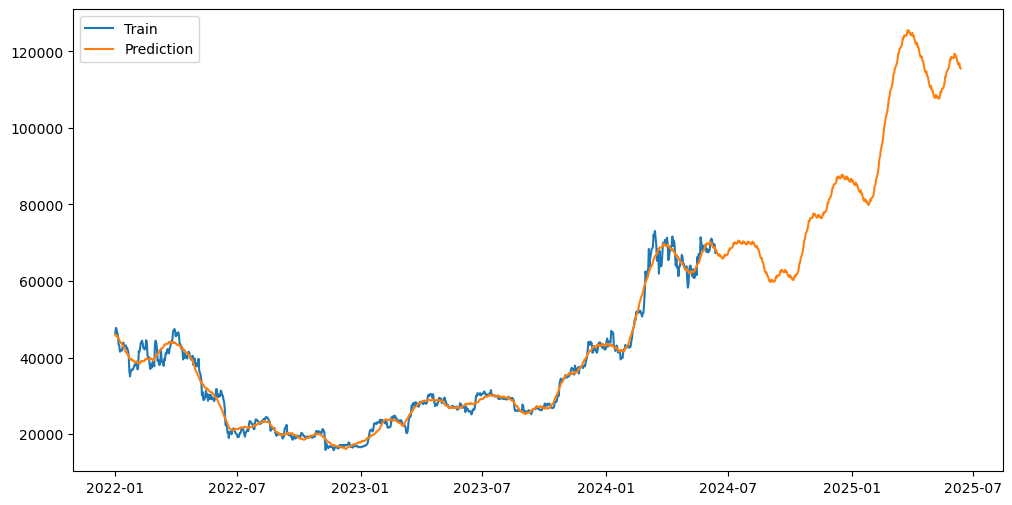

In [56]:
# 훈련 데이터(오늘까지)와 미래 예측(향후 1년) 데이터 그래프 시각화
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.plot(b_df[['y']], label='Train')
plt.plot(forecast_df[['yhat']], label='Prediction')
plt.legend()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


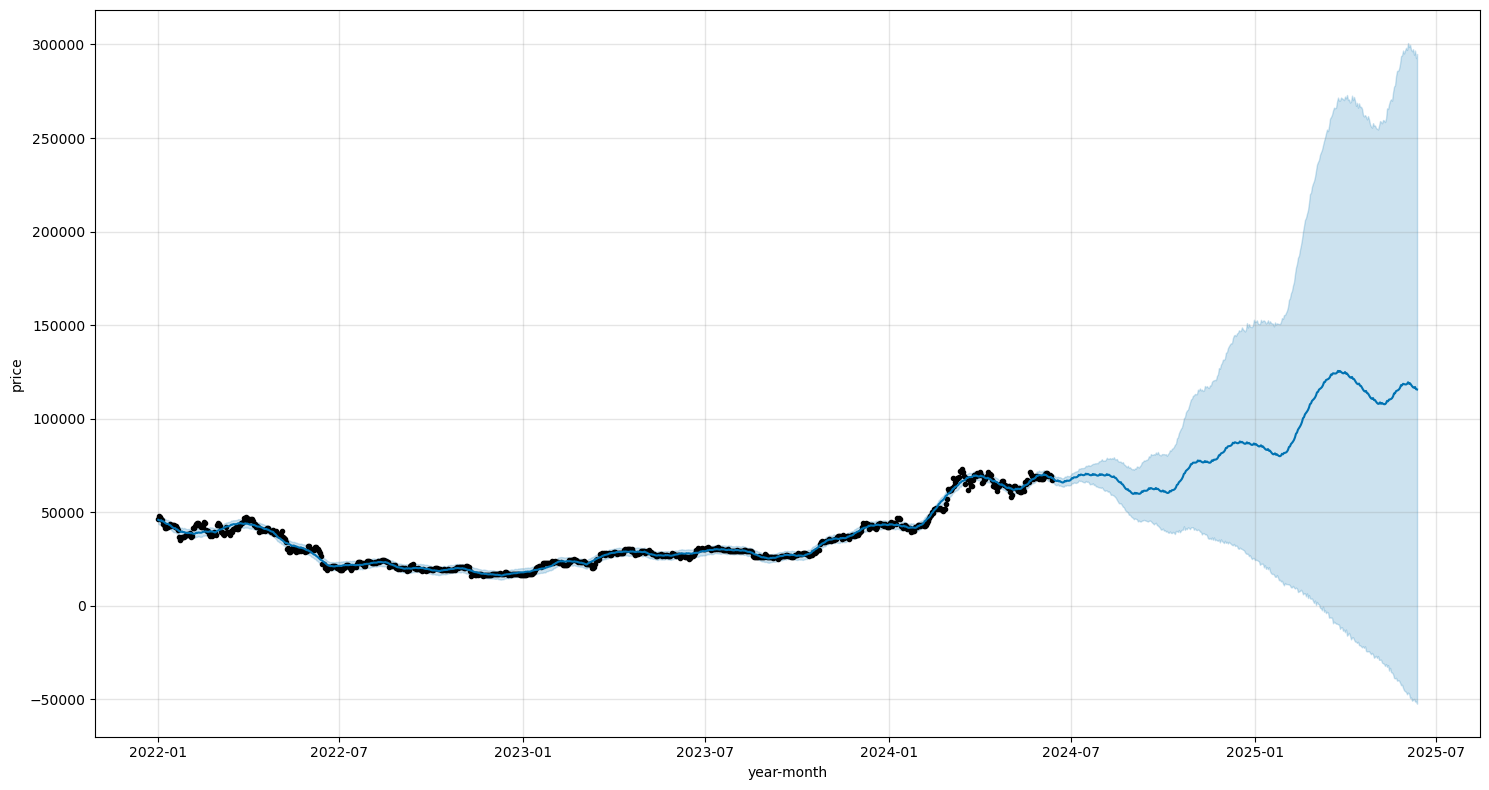

In [57]:
# 미래 예측 그래프와, 에측한 미래 데이터의 신뢰 구간 시각화 
model.plot(forecast, figsize=(15, 8), xlabel='year-month', ylabel='price')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\ProgramData\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

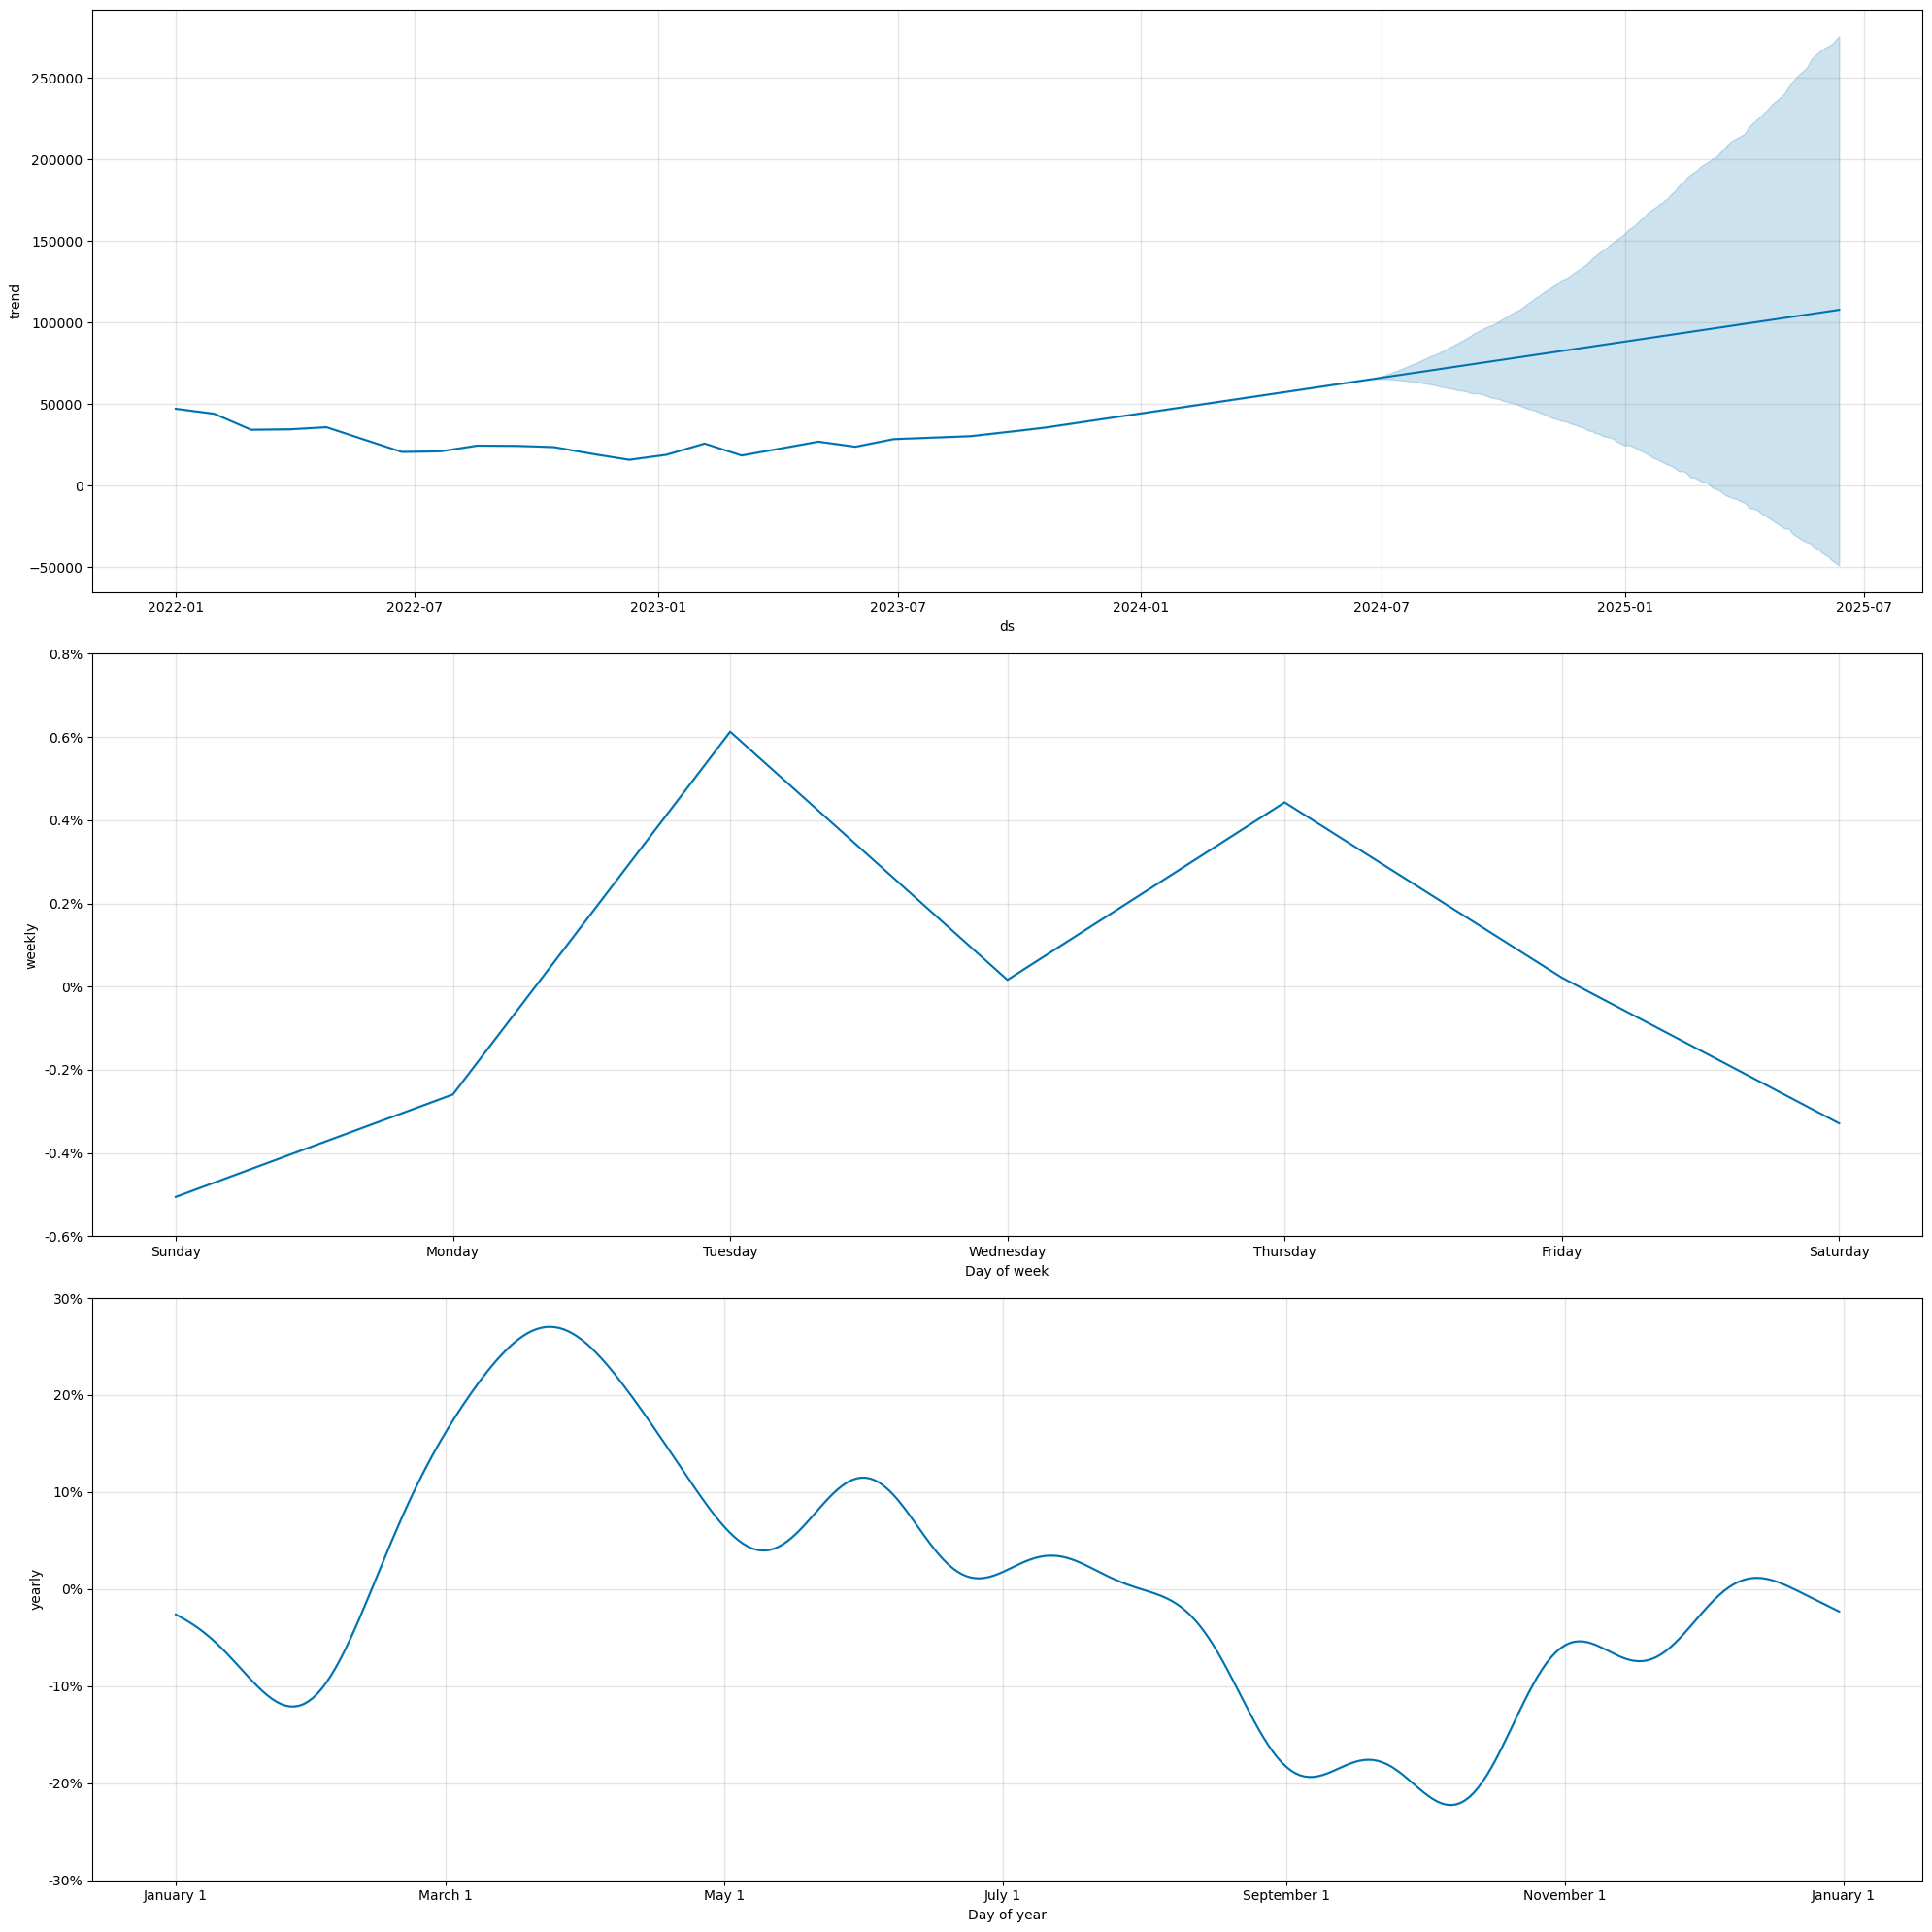

In [58]:
# 미래를 예측한 모델의 예측 데이터 + 신뢰 구간, 요일 별 주가 변화량, 계절에 따른 주가 변화 그래프 시각화
model.plot_components(forecast, figsize=(20, 20))
plt.show()